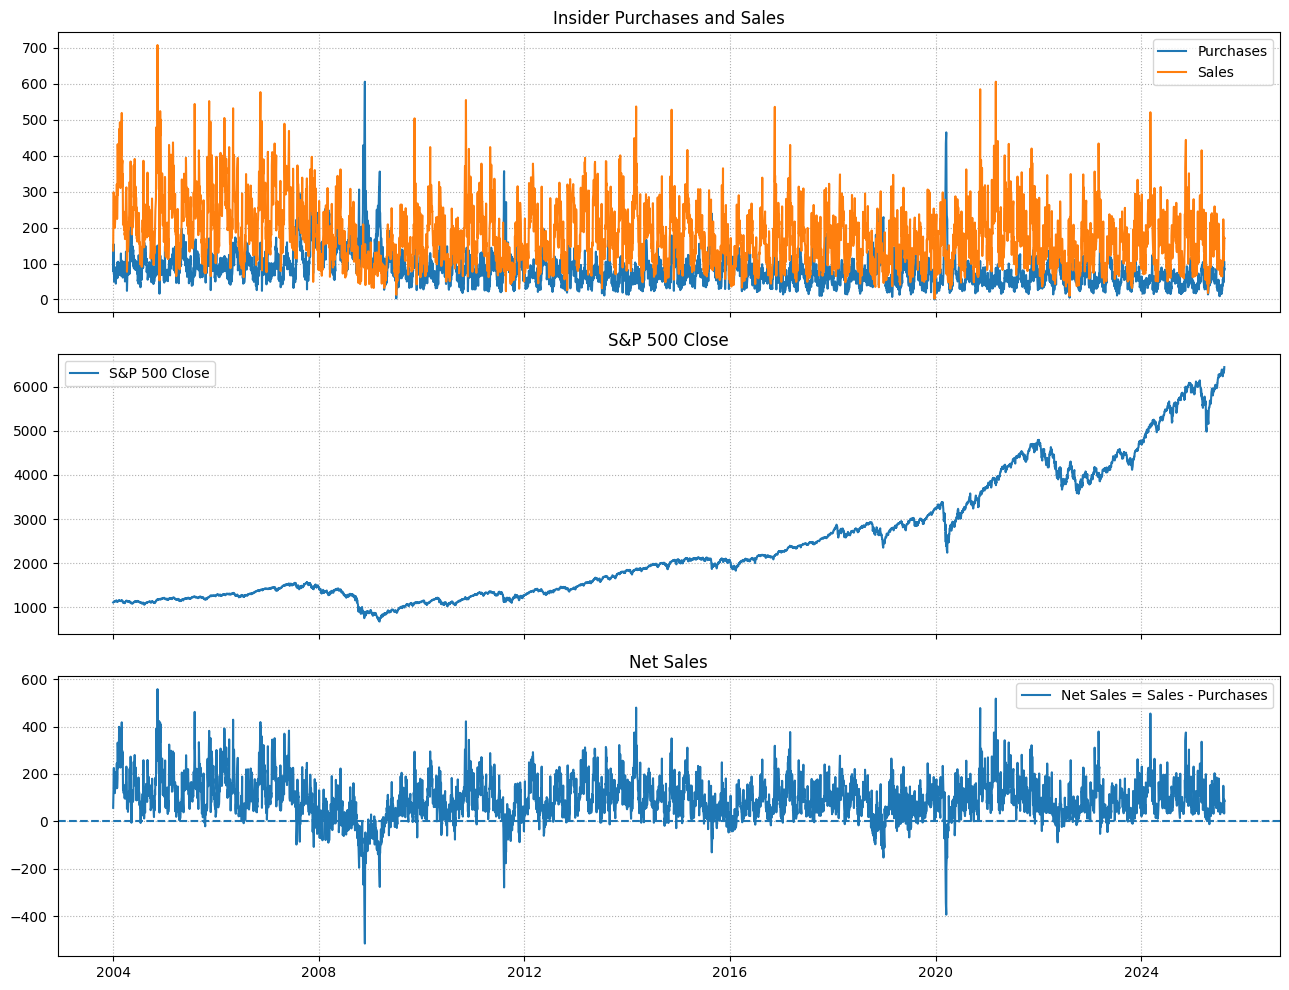

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# file paths
ins_path = r"Insider_data.csv"
spx_path = r"GSPC.csv"

# choose your window
start_date = "2004-01-01"   # set None to use the earliest
end_date   = "2025-08-13"   # set None to use the latest

# load data
ins = pd.read_csv(ins_path, parse_dates=["Date"]).sort_values("Date").set_index("Date")
spx = pd.read_csv(spx_path, parse_dates=["Date"]).sort_values("Date").set_index("Date")

# compute net
ins["Net"] = ins["Sales"] - ins["Purchases"]

# apply date filter
s = start_date if start_date is not None else ins.index.min()
e = end_date   if end_date   is not None else ins.index.max()

ins_win = ins.loc[s:e]
spx_win = spx.loc[s:e]

# plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

ax1.plot(ins_win.index, ins_win["Purchases"], label="Purchases")
ax1.plot(ins_win.index, ins_win["Sales"], label="Sales")
ax1.set_title("Insider Purchases and Sales")
ax1.legend()
ax1.grid(True, linestyle=":")

ax2.plot(spx_win.index, spx_win["Close"], label="S&P 500 Close")
ax2.set_title("S&P 500 Close")
ax2.legend()
ax2.grid(True, linestyle=":")

ax3.plot(ins_win.index, ins_win["Net"], label="Net Sales = Sales - Purchases")
ax3.axhline(0, linestyle="--")
ax3.set_title("Net Sales")
ax3.legend()
ax3.grid(True, linestyle=":")

plt.tight_layout()
plt.show()

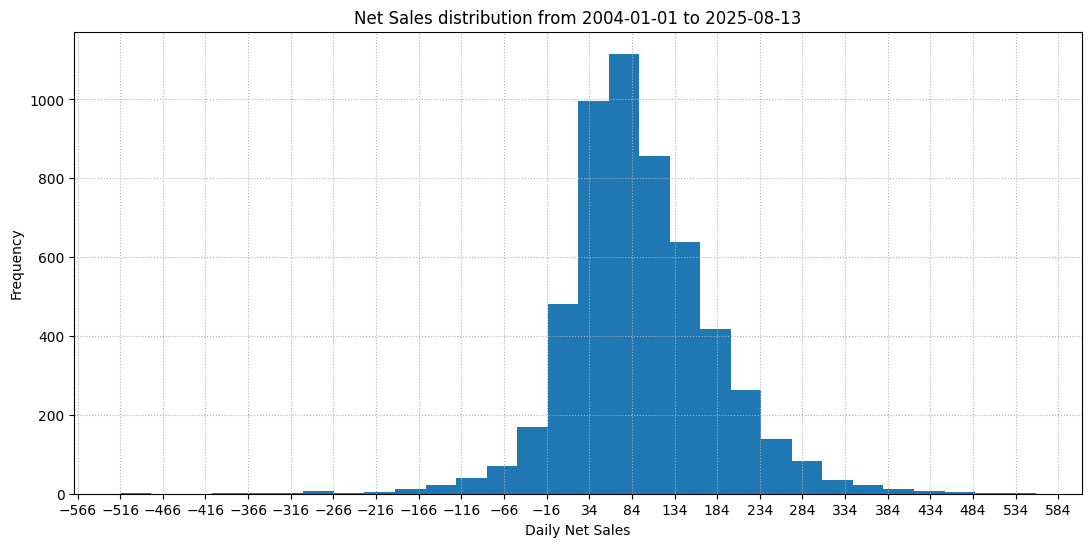

In [26]:
plt.figure(figsize=(13, 6))
plt.hist(ins_win["Net"].dropna(), bins=30)
plt.title(f"Net Sales distribution from {s} to {e}")
plt.xlabel("Daily Net Sales")
plt.ylabel("Frequency")
plt.grid(True, linestyle=":")

# add more detailed x axis ticks (every 50 units for example)
plt.xticks(range(int(ins_win["Net"].min())-50, int(ins_win["Net"].max())+50, 50))

plt.show()

In [29]:
x0 = -16  # set the cutoff
mask = ins_win["Net"] <= x0
area = mask.sum() / len(ins_win["Net"].dropna())

print(f"Area (proportion of data) left of {x0}: {area:.4f}")

Area (proportion of data) left of -16: 0.0601


Initial equity: 100,000.00
Final equity:   261,138.54
Total return:   161.14 percent
Number of buys: 3
Number of sells: 0


/var/folders/q4/bjpznc5x36vf08n1pndv92800000gn/T/ipykernel_83536/3474094199.py:43: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  buy_sig  = buy_sig.shift(1).fillna(False)
/var/folders/q4/bjpznc5x36vf08n1pndv92800000gn/T/ipykernel_83536/3474094199.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sell_sig = sell_sig.shift(1).fillna(False)


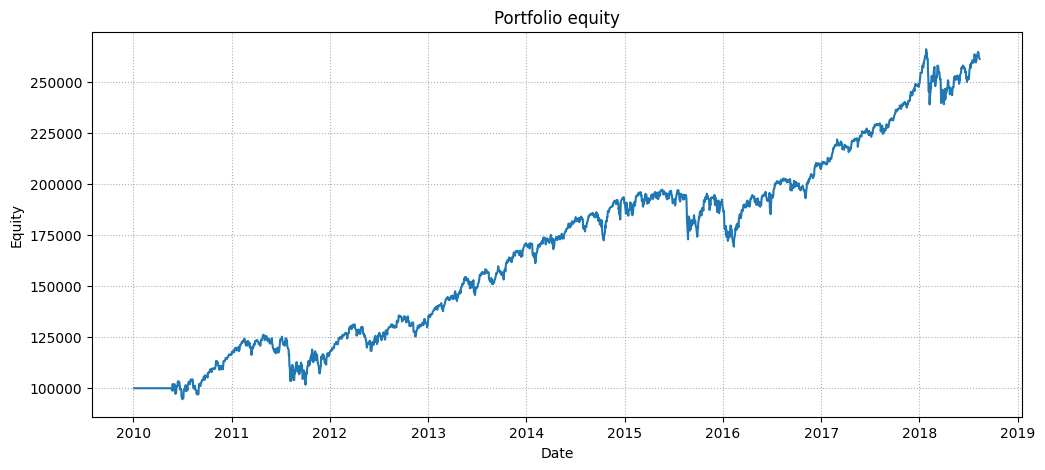

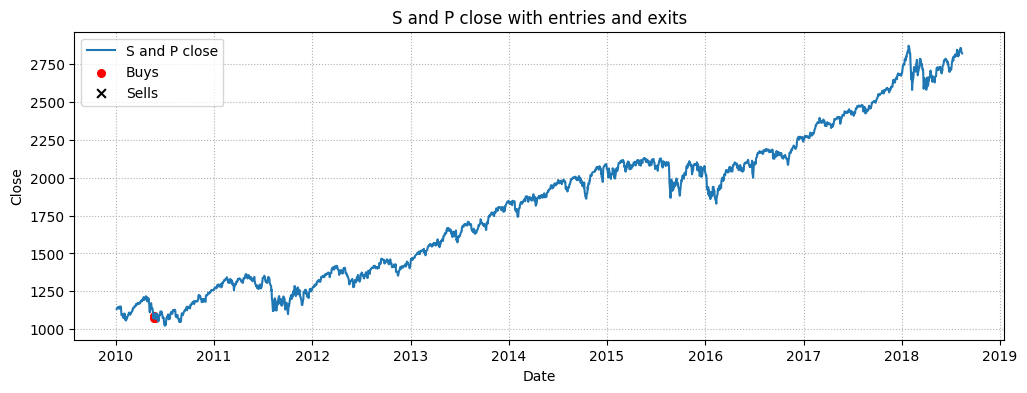

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# file paths
ins_path = r"Insider_data.csv"
spx_path = r"GSPC.csv"

# window
start_date = "2010-01-01"     # for example "2007-07-01"
end_date   = "2018-08-13"     # for example "2009-12-31"

# strategy params
initial_equity = 100_000.0
buy_threshold  = -16      # buy when Net < buy_threshold
sell_level     = 1000       # sell all when Net >= sell_level
buy_fraction   = 0.5      # invest fifteen percent of current equity each buy
use_next_close = True        # fill trades on the next close after the signal

# load data
ins = pd.read_csv(ins_path, parse_dates=["Date"]).sort_values("Date").set_index("Date")
spx = pd.read_csv(spx_path, parse_dates=["Date"]).sort_values("Date").set_index("Date")

# compute Net if needed
if "Net" not in ins.columns:
    ins["Net"] = ins["Sales"] - ins["Purchases"]

# apply window
s = pd.to_datetime(start_date) if start_date is not None else max(ins.index.min(), spx.index.min())
e = pd.to_datetime(end_date)   if end_date   is not None else min(ins.index.max(), spx.index.max())
ins_win = ins.loc[s:e]
spx_win = spx.loc[s:e]

# align insider info to trading dates
net_aligned = ins_win["Net"].reindex(spx_win.index, method="pad")

# entry and exit signals
buy_sig  = (net_aligned < buy_threshold).fillna(False)
sell_sig = (net_aligned >= sell_level).fillna(False)

# trade after the signal day if requested
if use_next_close:
    buy_sig  = buy_sig.shift(1).fillna(False)
    sell_sig = sell_sig.shift(1).fillna(False)

# state
cash = initial_equity
shares = 0.0

equity_path = []
trades = []

for dt, row in spx_win.iterrows():
    close = float(row["Close"])

    # exit first if both would trigger on the same bar
    if sell_sig.loc[dt] and shares > 0:
        proceeds = shares * close
        cash += proceeds
        trades.append({"Date": dt, "Action": "Sell all", "Price": close, "Qty": shares, "Cash_after": cash})
        shares = 0.0

    # entries
    if buy_sig.loc[dt]:
        equity_now = cash + shares * close
        buy_cash = min(buy_fraction * equity_now, cash)
        if buy_cash > 0:
            qty = buy_cash / close
            shares += qty
            cash -= buy_cash
            trades.append({"Date": dt, "Action": "Buy", "Price": close, "Qty": qty, "Cash_after": cash})

    # mark to market
    equity = cash + shares * close
    equity_path.append({"Date": dt, "Close": close, "Cash": cash, "Shares": shares, "Equity": equity})

equity_df = pd.DataFrame(equity_path).set_index("Date")
trades_df = pd.DataFrame(trades)

# summary
final_equity = float(equity_df["Equity"].iloc[-1])
total_return = final_equity / initial_equity - 1.0

print(f"Initial equity: {initial_equity:,.2f}")
print(f"Final equity:   {final_equity:,.2f}")
print(f"Total return:   {100*total_return:.2f} percent")
print(f"Number of buys: {(trades_df['Action'] == 'Buy').sum() if len(trades_df) else 0}")
print(f"Number of sells: {(trades_df['Action'] == 'Sell all').sum() if len(trades_df) else 0}")

# plots
plt.figure(figsize=(12, 5))
plt.plot(equity_df.index, equity_df["Equity"])
plt.title("Portfolio equity")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.grid(True, linestyle=":")
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(spx_win.index, spx_win["Close"], label="S and P close")
if len(trades_df):
    buys  = trades_df[trades_df["Action"] == "Buy"]
    sells = trades_df[trades_df["Action"] == "Sell all"]
    plt.scatter(buys["Date"], buys["Price"], s=30, marker="o", label="Buys", c = "r")
    plt.scatter(sells["Date"], sells["Price"], s=40, marker="x", label="Sells", c = "black")
plt.title("S and P close with entries and exits")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

# to inspect recent trades:
# trades_df.tail(10)

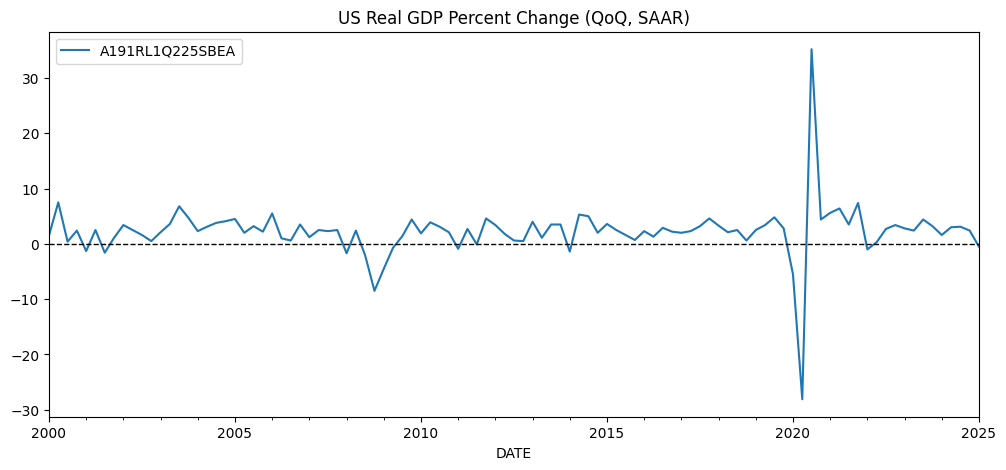

In [105]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

start = datetime.datetime(2000, 1, 1)
end   = datetime.datetime(2025, 1, 1)

us_gdp_growth = web.DataReader("A191RL1Q225SBEA", "fred", start, end)
ax = us_gdp_growth.plot(title="US Real GDP Percent Change (QoQ, SAAR)", figsize=(12,5))
ax.axhline(0, color="black", linestyle="--", linewidth=1)  # line at zero
plt.show()

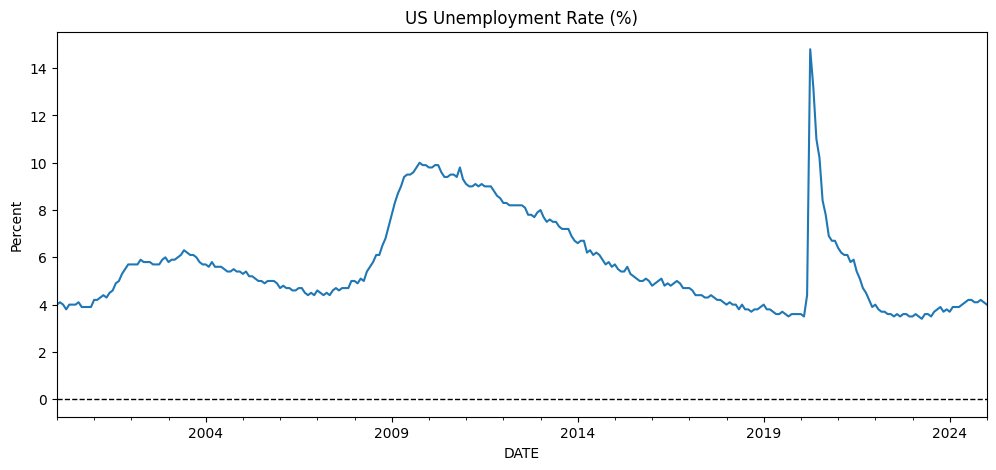

            UNRATE
DATE              
2024-09-01     4.1
2024-10-01     4.1
2024-11-01     4.2
2024-12-01     4.1
2025-01-01     4.0


In [106]:
import pandas_datareader.data as web
import datetime
import matplotlib.pyplot as plt

start = datetime.datetime(2000, 1, 1)
end   = datetime.datetime(2025, 1, 1)

# Unemployment rate (monthly, percent)
us_unemp = web.DataReader("UNRATE", "fred", start, end)

# Plot
ax = us_unemp.plot(title="US Unemployment Rate (%)", figsize=(12,5), legend=False)
ax.axhline(0, color="black", linestyle="--", linewidth=1)  # linea dello 0 solo come riferimento
plt.ylabel("Percent")
plt.show()

print(us_unemp.tail())

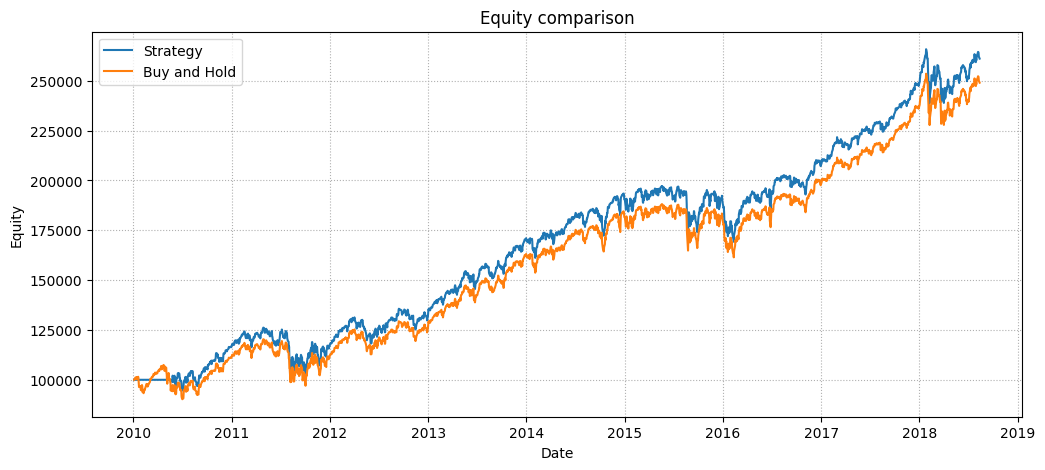

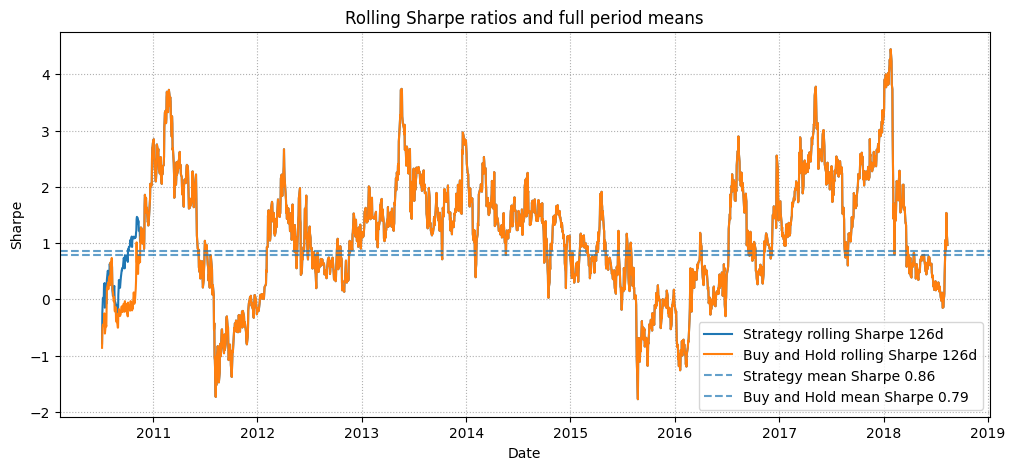

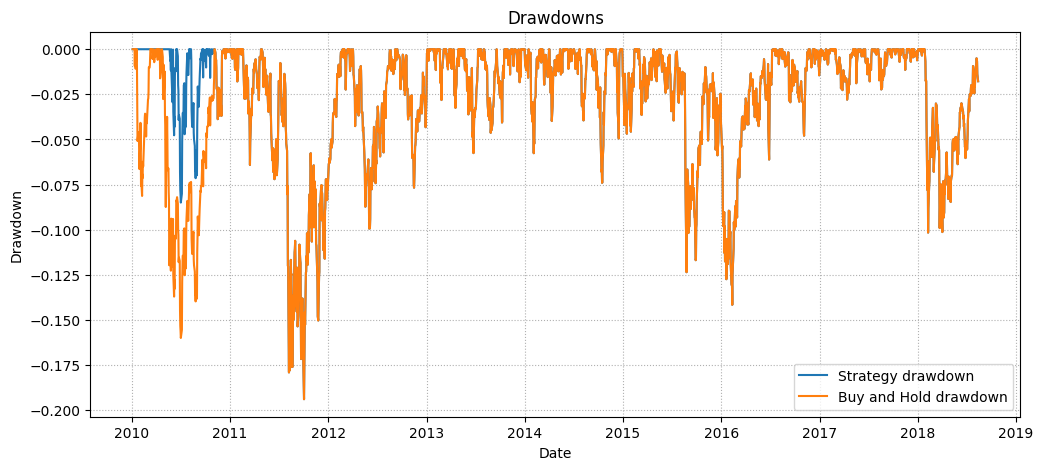

In [107]:
# ===== Benchmarks and analytics =====

# buy and hold with all capital
bh_equity = initial_equity * (spx_win["Close"] / spx_win["Close"].iloc[0])

# combine for comparison
comp_df = pd.DataFrame({
    "Strategy": equity_df["Equity"],
    "BuyHold": bh_equity
})

# 1. equity comparison
plt.figure(figsize=(12, 5))
plt.plot(comp_df.index, comp_df["Strategy"], label="Strategy")
plt.plot(comp_df.index, comp_df["BuyHold"], label="Buy and Hold")
plt.title("Equity comparison")
plt.xlabel("Date")
plt.ylabel("Equity")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

# 2. Sharpe ratios
def annualized_sharpe(returns, periods_per_year=252):
    r = returns.dropna()
    if r.std() == 0:
        return np.nan
    return np.sqrt(periods_per_year) * r.mean() / r.std()

# daily returns from equity curves
strat_ret = comp_df["Strategy"].pct_change()
bh_ret    = comp_df["BuyHold"].pct_change()

# choose rolling window in trading days
rolling_window = 126  # about six months

roll_sharpe_strat = strat_ret.rolling(rolling_window).apply(
    lambda x: np.sqrt(252) * x.mean() / x.std() if np.std(x, ddof=1) != 0 else np.nan,
    raw=False
)
roll_sharpe_bh = bh_ret.rolling(rolling_window).apply(
    lambda x: np.sqrt(252) * x.mean() / x.std() if np.std(x, ddof=1) != 0 else np.nan,
    raw=False
)

mean_sharpe_strat = annualized_sharpe(strat_ret)
mean_sharpe_bh    = annualized_sharpe(bh_ret)

plt.figure(figsize=(12, 5))
plt.plot(roll_sharpe_strat, label=f"Strategy rolling Sharpe {rolling_window}d")
plt.plot(roll_sharpe_bh, label=f"Buy and Hold rolling Sharpe {rolling_window}d")
plt.axhline(mean_sharpe_strat, linestyle="--", alpha=0.7, label=f"Strategy mean Sharpe {mean_sharpe_strat:.2f}")
plt.axhline(mean_sharpe_bh, linestyle="--", alpha=0.7, label=f"Buy and Hold mean Sharpe {mean_sharpe_bh:.2f}")
plt.title("Rolling Sharpe ratios and full period means")
plt.xlabel("Date")
plt.ylabel("Sharpe")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

# 3. Drawdowns
def drawdown(equity_series):
    peak = equity_series.cummax()
    return equity_series / peak - 1.0

dd_strat = drawdown(comp_df["Strategy"])
dd_bh    = drawdown(comp_df["BuyHold"])

plt.figure(figsize=(12, 5))
plt.plot(dd_strat, label="Strategy drawdown")
plt.plot(dd_bh, label="Buy and Hold drawdown")
plt.title("Drawdowns")
plt.xlabel("Date")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(True, linestyle=":")
plt.show()

In [95]:
# Count buys and sells from the trade log
num_buys  = (trades_df["Action"] == "Buy").sum()
num_sells = (trades_df["Action"] == "Sell all").sum()

print(f"Number of Buy trades:  {num_buys}")
print(f"Number of Sell trades: {num_sells}")

Number of Buy trades:  75
Number of Sell trades: 0


In [ ]:
/Users/tommasomarrucci/Desktop/My projects/Open Insider